* Update: changing the batch_size from 32 to 128 when warm up the model, adding Kappa loss from this kernel: https://www.kaggle.com/christofhenkel/weighted-kappa-loss-for-keras-tensorflow

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['aptos2019-blindness-detection', 'resnet50']


In [2]:
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.applications.resnet50 import preprocess_input
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score, cohen_kappa_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
SIZE = 300
NUM_CLASSES = 5

Using TensorFlow backend.


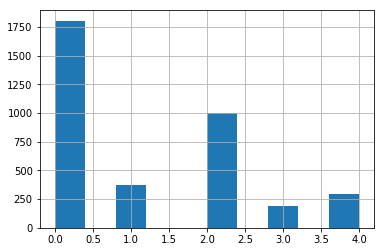

In [3]:
df_train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
df_test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

x = df_train['id_code']
y = df_train['diagnosis']

x, y = shuffle(x, y, random_state=8)
y.hist()


In [4]:
def to_multi_label(target):
    multi_label = np.zeros((len(target), NUM_CLASSES))
    for i in range(len(target)):
        j = target[i] + 1
        multi_label[i][:j] = 1
    return np.array(multi_label)

In [5]:
# y = to_categorical(y, num_classes=NUM_CLASSES)
multi_y = to_multi_label(y)
train_x, valid_x, train_y, valid_y = train_test_split(x, multi_y, test_size=0.15,
                                                      stratify=y, random_state=8)
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

(3112,)
(3112, 5)
(550,)
(550, 5)


In [6]:
# https://github.com/aleju/imgaug
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential([
    sometimes(
        iaa.OneOf([
            iaa.Add((-10, 10), per_channel=0.5),
            iaa.Multiply((0.9, 1.1), per_channel=0.5),
            iaa.ContrastNormalization((0.9, 1.1), per_channel=0.5)
        ])
    ),
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0, 0.1)),
    iaa.Flipud(0.5)
],random_order=True)


In [7]:
class My_Generator(Sequence):

    def __init__(self, image_filenames, labels,
                 batch_size, is_train=False,
                 mix=False, augment=False):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size
        self.is_train = is_train
        self.is_augment = augment
        if(self.is_train):
            self.on_epoch_end()
        self.is_mix = mix

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        if(self.is_train):
            return self.train_generate(batch_x, batch_y)
        return self.valid_generate(batch_x, batch_y)

    def on_epoch_end(self):
        if(self.is_train):
            self.image_filenames, self.labels = shuffle(self.image_filenames, self.labels)
    
    def mix_up(self, x, y):
        lam = np.random.beta(0.2, 0.4)
        ori_index = np.arange(int(len(x)))
        index_array = np.arange(int(len(x)))
        np.random.shuffle(index_array)        
        
        mixed_x = lam * x[ori_index] + (1 - lam) * x[index_array]
        mixed_y = lam * y[ori_index] + (1 - lam) * y[index_array]
        
        return mixed_x, mixed_y

    def train_generate(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):
            img = cv2.imread('../input/aptos2019-blindness-detection/train_images/'+sample+'.png')
            img = cv2.resize(img, (SIZE, SIZE))
            img = np.fft.fft2(img)
            img = np.log(np.abs(img))
            if(self.is_augment):
                img = seq.augment_image(img)
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32) / 255
        batch_y = np.array(batch_y, np.float32)
        if(self.is_mix):
            batch_images, batch_y = self.mix_up(batch_images, batch_y)
        return batch_images, batch_y

    def valid_generate(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):
            img = cv2.imread('../input/aptos2019-blindness-detection/train_images/'+sample+'.png')
            img = cv2.resize(img, (SIZE, SIZE))
            img = np.fft.fft2(img)
            img = np.log(np.abs(img))
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32) / 255
        batch_y = np.array(batch_y, np.float32)
        return batch_images, batch_y

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D)
from keras.applications.resnet50 import ResNet50
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras
from keras.models import Model

In [9]:
function = "sigmoid"
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = ResNet50(include_top=False,
                   weights=None,
                   input_tensor=input_tensor)
    base_model.load_weights('../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.3)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.3)(x)
    final_output = Dense(n_out, activation=function, name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

In [10]:
# create callbacks list
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)

epochs = 10; batch_size = 40
checkpoint = ModelCheckpoint('../working/Resnet50.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, 
                                   verbose=1, mode='auto', epsilon=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=9)

csv_logger = CSVLogger(filename='../working/training_log.csv',
                       separator=',',
                       append=True)
# callbacks_list = [checkpoint, csv_logger, reduceLROnPlat, early]

train_generator = My_Generator(train_x, train_y, 128, is_train=True)
train_mixup = My_Generator(train_x, train_y, batch_size, is_train=True, mix=False, augment=True)
valid_generator = My_Generator(valid_x, valid_y, batch_size, is_train=False)

model = create_model(
    input_shape=(SIZE,SIZE,3), 
    n_out=NUM_CLASSES)

In [11]:
from keras.callbacks import Callback
class QWKEvaluation(Callback):
    def __init__(self, validation_data=(), batch_size=64, interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.batch_size = batch_size
        self.valid_generator, self.y_val = validation_data
        self.history = []

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict_generator(generator=self.valid_generator,
                                                  steps=np.ceil(float(len(self.y_val)) / float(self.batch_size)),
                                                  workers=1, use_multiprocessing=False,
                                                  verbose=1) > 0.5
            def flatten(y):
                # return np.argmax(y, axis=1).reshape(-1)
                return np.sum(y.astype(int), axis=1).reshape(-1) - 1
            
            score = cohen_kappa_score(flatten(self.y_val),
                                      flatten(y_pred),
                                      labels=[0,1,2,3,4],
                                      weights='quadratic')
            print("\n epoch: %d - QWK_score: %.6f \n" % (epoch+1, score))
            self.history.append(score)
            if score >= max(self.history):
                print('save checkpoint: ', score)
                self.model.save('../working/Resnet50_bestqwk.h5')

qwk = QWKEvaluation(validation_data=(valid_generator, valid_y),
                    batch_size=batch_size, interval=1)

In [12]:
# warm up model
for layer in model.layers:
    layer.trainable = False

for i in range(-3,0):
    model.layers[i].trainable = True

model.compile(
#     loss ='categorical_crossentropy',
    loss = 'binary_crossentropy',
    optimizer=Adam(1e-3))

model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(float(len(train_y)) / float(128)),
    epochs=2,
    workers=WORKERS, use_multiprocessing=True,
    verbose=1,
    callbacks=[qwk])

Epoch 1/2
14/14 [==============================] - 110s 8s/step

 epoch: 1 - QWK_score: 0.000000 

save checkpoint:  0.0
Epoch 2/2
14/14 [==============================] - 110s 8s/step

 epoch: 2 - QWK_score: 0.000000 

save checkpoint:  0.0


In [ ]:
# train all layers
for layer in model.layers:
    layer.trainable = True

callbacks_list = [checkpoint, csv_logger, reduceLROnPlat, qwk]
model.compile(# loss='categorical_crossentropy',
            # loss=kappa_loss,
            loss='binary_crossentropy',
            optimizer=Adam(lr=5e-5))

model.fit_generator(
    train_mixup,
    steps_per_epoch=np.ceil(float(len(train_x)) / float(batch_size)),
    validation_data=valid_generator,
    validation_steps=np.ceil(float(len(valid_x)) / float(batch_size)),
    epochs=epochs,
    verbose=1,
    workers=1, use_multiprocessing=False,
    callbacks=callbacks_list)

Epoch 1/10
78/78 [==============================] - 330s 4s/step - loss: 0.4181 - val_loss: 0.4459

Epoch 00001: val_loss improved from inf to 0.44586, saving model to ../working/Resnet50.h5
14/14 [==============================] - 88s 6s/step

 epoch: 1 - QWK_score: 0.000000 

save checkpoint:  0.0
Epoch 2/10
78/78 [==============================] - 267s 3s/step - loss: 0.4163 - val_loss: 0.4298

Epoch 00002: val_loss improved from 0.44586 to 0.42981, saving model to ../working/Resnet50.h5
14/14 [==============================] - 86s 6s/step

 epoch: 2 - QWK_score: 0.000000 

save checkpoint:  0.0
Epoch 3/10
78/78 [==============================] - 262s 3s/step - loss: 0.4145 - val_loss: 0.4165

Epoch 00003: val_loss improved from 0.42981 to 0.41646, saving model to ../working/Resnet50.h5
14/14 [==============================] - 85s 6s/step

 epoch: 3 - QWK_score: 0.000000 

save checkpoint:  0.0
Epoch 4/10
78/78 [==============================] - 260s 3s/step - loss: 0.4153 - val_los

In [ ]:
submit = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
# model.load_weights('../working/Resnet50.h5')
model.load_weights('../working/Resnet50_bestqwk.h5')
predicted = []

In [ ]:
for i, name in tqdm(enumerate(submit['id_code'])):
    path = os.path.join('../input/aptos2019-blindness-detection/test_images/', name+'.png')
    image = cv2.imread(path)
    image = cv2.resize(image, (SIZE, SIZE))
    img = np.fft.fft2(img)
    img = np.log(np.abs(img))
    score_predict = model.predict((image[np.newaxis])/255) > 0.5
    # label_predict = np.argmax(score_predict)
    label_predict = score_predict.astype(int).sum() - 1
    predicted.append(str(label_predict))

In [ ]:
submit['diagnosis'] = predicted
submit.to_csv('submission.csv', index=False)
submit.head()